# Анализ Оттока Водителей Такси


## Описание проекта
Есть данные о такси-компании (uber), которая хочет изучить отток водителей и посмотреть, какие есть различия между водителями, которые покидают сервис, и которые остаются. 

Нужно сформулировать и протестировать гипотезы, выделить группы водителей, которые наиболее подвержены "оттоку". На основе результатов сделать выводы о том, что можно улучшить в сервисе, чтобы в дальнейшем внести изменения (и после – провести A/B тест и выяснить, стало ли лучше).

### Описание данных

- `city` – город
- `phone` – основное устройство, которое использует водитель 
- `signup_date` – дата регистрации аккаунта (`YYYYMMDD`)
- `last_trip_date` – дата последней поездки (`YYYYMMDD`)
- `avg_dist` – среднее расстояние (в милях) за поездку в первые 30 дней после регистрации
- `avg_rating_by_driver` – средняя оценка поездок водителем 
- `avg_rating_of_driver` – средняя оценка поездок водителя
- `surge_pct` – процент поездок, совершенных с множителем > 1 (кажется когда большая загруженность и тд)
- `avg_surge` – средний множитель всплеска за все поездки этого водителя
- `trips_in_first_30_days` – количество поездок, которые совершил водитель в первые 30 дней после регистрации
- `luxury_car_user` – TRUE, если пользователь в первые 30 дней использовал премиум-автомобиль
- `weekday_pct` – процент поездок пользователя, совершенных в будние дни



## Загрузка данных

In [111]:
import numpy as np
import pandas as pd
import scipy.stats as ss
import pingouin as pg
import seaborn as sns
import matplotlib.pyplot as plt

import requests
from urllib.parse import urlencode

In [112]:
def url_ydisk (url):    
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    public_key = url
    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url)
    download_url = response.json()['href']
    return download_url  

In [113]:
df = pd.read_csv(url_ydisk('https://disk.yandex.ru/d/QRIZZgq_JLEGiw'))

In [114]:
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [115]:
df.shape

(50000, 12)

In [116]:
df.isna().sum()

avg_dist                     0
avg_rating_by_driver       201
avg_rating_of_driver      8122
avg_surge                    0
city                         0
last_trip_date               0
phone                      396
signup_date                  0
surge_pct                    0
trips_in_first_30_days       0
luxury_car_user              0
weekday_pct                  0
dtype: int64

In [117]:
df.nunique()

avg_dist                  2908
avg_rating_by_driver        27
avg_rating_of_driver        37
avg_surge                  115
city                         3
last_trip_date             182
phone                        2
signup_date                 31
surge_pct                  367
trips_in_first_30_days      59
luxury_car_user              2
weekday_pct                666
dtype: int64

In [118]:
df.dtypes

avg_dist                  float64
avg_rating_by_driver      float64
avg_rating_of_driver      float64
avg_surge                 float64
city                       object
last_trip_date             object
phone                      object
signup_date                object
surge_pct                 float64
trips_in_first_30_days      int64
luxury_car_user              bool
weekday_pct               float64
dtype: object

Изменяем тип для дат:


In [119]:
df.last_trip_date = pd.to_datetime(df.last_trip_date)
df.signup_date = pd.to_datetime(df.signup_date)

In [120]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   avg_dist                50000 non-null  float64       
 1   avg_rating_by_driver    49799 non-null  float64       
 2   avg_rating_of_driver    41878 non-null  float64       
 3   avg_surge               50000 non-null  float64       
 4   city                    50000 non-null  object        
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   49604 non-null  object        
 7   signup_date             50000 non-null  datetime64[ns]
 8   surge_pct               50000 non-null  float64       
 9   trips_in_first_30_days  50000 non-null  int64         
 10  luxury_car_user         50000 non-null  bool          
 11  weekday_pct             50000 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

In [121]:
df.describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct
count,50000.000000,49799.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,5.796827,4.778158,4.601559,1.074764,8.849536,2.278200,60.926084
std,5.707357,0.446652,0.617338,0.222336,19.958811,3.792684,37.081503
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,2.420000,4.700000,4.300000,1.000000,0.000000,0.000000,33.300000
50%,3.880000,5.000000,4.900000,1.000000,0.000000,1.000000,66.700000
75%,6.940000,5.000000,5.000000,1.050000,8.600000,3.000000,100.000000
max,160.960000,5.000000,5.000000,8.000000,100.000000,125.000000,100.000000


In [122]:
df.describe(include='object')

,city,phone
count,50000,49604
unique,3,2
top,Winterfell,iPhone
freq,23336,34582


In [123]:
df.describe(include='datetime', datetime_is_numeric=True)

,last_trip_date,signup_date
count,50000,50000
mean,2014-04-19 08:02:04.992000256,2014-01-16 13:04:20.352000
min,2014-01-01 00:00:00,2014-01-01 00:00:00
25%,2014-02-14 00:00:00,2014-01-09 00:00:00
50%,2014-05-08 00:00:00,2014-01-17 00:00:00
75%,2014-06-18 00:00:00,2014-01-24 00:00:00
max,2014-07-01 00:00:00,2014-01-31 00:00:00


## Гипотезы и стат тесты

Создаем лейбл churn – пользователь ушел, если не был активен последние 30 дней (но можно попробовать и другие значения в зависимости от вашей компании/данных)

В качестве текущей даты возьмем последнеднюю зафиксированную дату.

In [124]:
max_date = df.last_trip_date.max()

In [125]:
df['days_since_last_trip'] = max_date - df.last_trip_date

Преобразуем в int:

In [126]:
df['days_since_last_trip'] = df['days_since_last_trip'].dt.days

In [127]:
df['days_since_last_trip'].head()

0     14
1     57
2    175
3      2
4    108
Name: days_since_last_trip, dtype: int64

In [128]:
df['churn'] = df.days_since_last_trip.apply(lambda x: 'churn' if x > 30 else 'not_churn')
df[['days_since_last_trip', 'churn']].head()

,days_since_last_trip,churn
0,14,not_churn
1,57,churn
2,175,churn
3,2,not_churn
4,108,churn


## churn
Посмотрим на соотношение водителей, которые активно пользуются приложением, и водителей, которые не проявляли активность месяц.

In [129]:
churn_counts = df['churn'].value_counts().reset_index()
churn_counts.columns = ['churn', 'count']
churn_counts

,churn,count
0,churn,31196
1,not_churn,18804


In [130]:
df.churn.value_counts(normalize=True).mul(100)

churn        62.392
not_churn    37.608
Name: churn, dtype: float64

Видим, что очень много пользователей не использовали сервис в последнем месяце. Разберем, какие факторы могли повлиять на отток водителей.

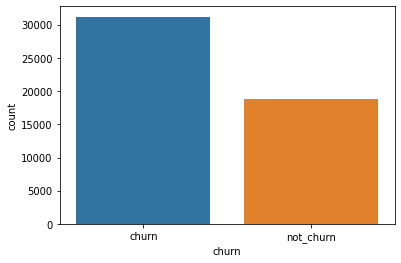

In [131]:
# Построение столбчатой диаграммы
sns.barplot(data=churn_counts, x='churn', y='count')

## churn & phone

Предположим, что проблема может быть среди юзеров на конкретной платформе:

In [132]:
#count_df = df.groupby(['churn', 'phone']).size().reset_index(name='count')
pd.crosstab(df.churn, df.phone)

phone,Android,iPhone
churn,,
churn,11876,19057
not_churn,3146,15525


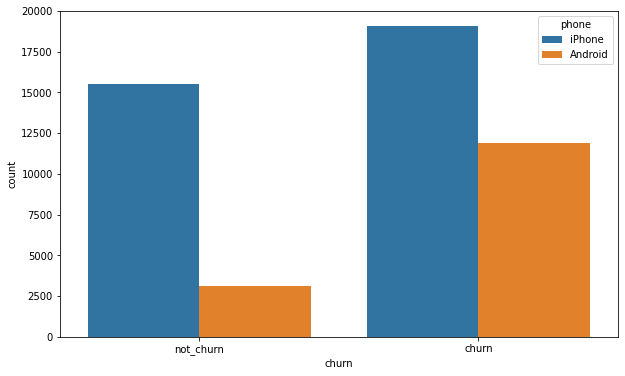

In [133]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df[['churn', 'phone']].dropna(), x='churn', hue='phone')

Проверим нашу гипотезу с помощью статистического теста.

Есть две категориальные переменные (phone/churn) → нужен хи-квадрат

- $H_0$: взаимосвязи между переменными нет 
- $H_1$: взаимосвязь есть

In [134]:
stat, p_value, dof, expected = ss.chi2_contingency(pd.crosstab(df.churn, df.phone))

In [135]:
stat, p_value

(2558.394212267425, 0.0)

In [136]:
p_value < 0.05 

True

**Вывод:** p-value < 0.05 → существует статистически значимое различие между группами. 

## churn & city

Посмотрим на различия в размерах оттока клиентов в разных городах (есть ли взаимосвзяь между городом и тем, уйдет ли водитель).


In [137]:
pd.crosstab(df.churn, df.city)

city,Astapor,King's Landing,Winterfell
churn,,,
churn,12306,3767,15123
not_churn,4228,6363,8213


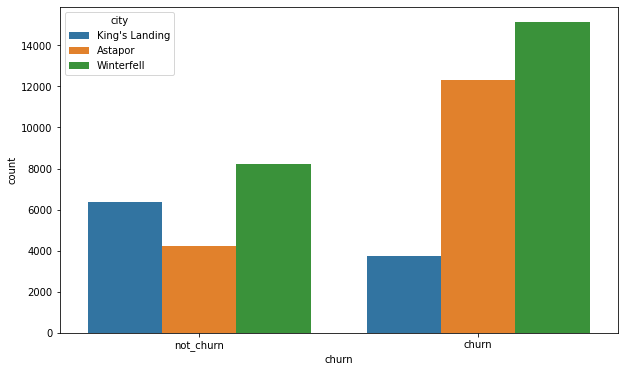

In [138]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df[['churn', 'city']].dropna(), x='churn', hue='city')

Есть две категориальные переменные (city/churn) → нужен хи-квадрат

- $H_0$: взаимосвязи между переменными нет 
- $H_1$: взаимосвязь есть

In [144]:
stat, p, dof, expected = ss.chi2_contingency(pd.crosstab(df.churn, df.city))

In [145]:
stat, p

(3821.5510225559633, 0.0)

In [146]:
p_value < 0.05 

True

**Вывод:** p-value < 0.05 → существует статистически значимое различие между группами. 

### city & trips_in_first_30_days
Есть ли разница в активности в первые 30 дней с момента регистрации между водителями из разных городов? (city, trips_in_first_30_days)

Чтобы выбрать стат тест, проведем тест на нормальность распределений переменных.

In [147]:
pg.normality(data=df, dv="trips_in_first_30_days", group="city", method="normaltest")

,W,pval,normal
King's Landing,12011.013892,0.0,False
Astapor,18186.739338,0.0,False
Winterfell,21390.545655,0.0,False


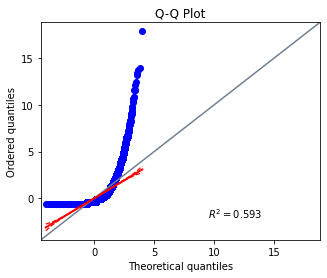

In [148]:
pg.qqplot(df.query("city == 'Winterfell'").trips_in_first_30_days)

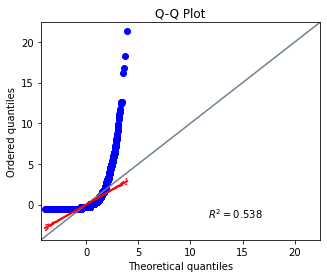

In [149]:
pg.qqplot(df.query("city == 'Astapor'").trips_in_first_30_days)

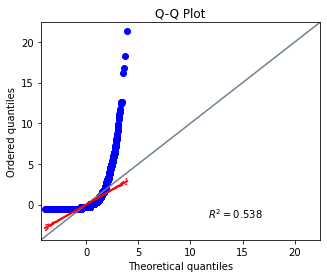

In [150]:
pg.qqplot(df[df.city == 'Astapor'].trips_in_first_30_days)

В ходе неоднократной проверки пришли к выводу, что переменные распределены ненормально.

Распределения не являются нормальными, поэтому используем непараметрический аналог ANOVA – критерий Краскела-Уоллиса.

In [151]:
# df.groupby('city')['trips_in_first_30_days'].apply(list)

# Выполнение теста Краскела-Уоллиса
ss.kruskal(df.query("city == 'Winterfell'").trips_in_first_30_days,
           df.query("city == 'Astapor'").trips_in_first_30_days,
           df[df.city == 'Astapor'].trips_in_first_30_days)

KruskalResult(statistic=320.6835184060202, pvalue=2.3145083902719496e-70)

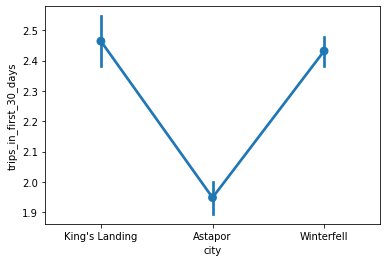

In [152]:
sns.pointplot(data=df, x='city', y='trips_in_first_30_days')

**Вывод**: p_value < 0.05 --> отклоянем нулевую гипотезу. Обнаружены ли статистически значимые различия в активности в первые 30 дней с момента регистрации между водителями из разных городов.


## churn & trips_in_first_30_days
Может ли отток быть связан с активностью в первые 30 дней после регистрации? (churn, trips_in_first_30_days)

In [153]:
pg.normality(data=df, dv="trips_in_first_30_days", group="churn", method="normaltest")

,W,pval,normal
not_churn,16960.202341,0.0,False
churn,36325.245749,0.0,False


Распределение переменной trips_in_first_30_days ненормально, поэтому для проверки гипотезы я использую тест Манна-Уитни

In [154]:
# Разделение данных по оттоку
churn = df.query('churn == "churn"').trips_in_first_30_days
not_churn = df.query('churn == "not_churn"').trips_in_first_30_days

In [155]:
# Проведение теста Манна-Уитни
ss.mannwhitneyu(churn, not_churn)

MannwhitneyuResult(statistic=234767452.0, pvalue=0.0)

**Вывод:** p-value < 0.05 → существует статистически значимое различие между группами, ушедшие пользователи был менее активны.

## Заключение
На основе результатов анализа были выявлены ключевые факторы, влияющие на отток водителей. Рекомендуется провести дополнительные мероприятия для повышения активности водителей в первые 30 дней и уменьшения оттока.
